In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
import time
import boto3
import pyarrow
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src import eda as eda
from src import fixdependencia as fixdependencia

# EDA introductorio inicial

Este EDA contiene las respuestas a los siguientes issues:
* #15: [Mini EDA de tipos de archivo y cantidades de archivos en ZIP.](cellIss15) / [ver issue](https://github.com/sociedat/score-respuesta-inai/issues/15)
* #19: Definición final de variable "calidad_respuesta" y "calidad_respuesta_real" / [ver issue](https://github.com/sociedat/score-respuesta-inai/issues/19)
* #20: Mini EDA de respuestas con URL inválido en columna ARCHIVO / [ver issue](https://github.com/sociedat/score-respuesta-inai/issues/20)
* #24: EDA de calidad de respuestas [ver issue](https://github.com/sociedat/score-respuesta-inai/issues/24)
* #32: Complementar EDA: Distinct de dominios en registros de columna ARCHIVO [ver issue](https://github.com/sociedat/score-respuesta-inai/issues/32)

## Importamos datos raw

Definimos el bucket de la S3 y el folder donde ese encuentra el archivo inai.parquet que importaremos con la información de 2012 a 2019.

In [3]:
bucket = 'inai-summerofdata'
folder = 'parquet'

In [4]:
f = f's3://{bucket}/{folder}/inai.parquet'
df = pd.read_parquet(f, engine='pyarrow')
df = df[df['TIPOSOLICITUD']=='Información Pública']
df.head()
df1 = df.copy()
df_orig = df.copy()
original = df.copy()

 <a id='cellIss15'></a>
## #15: Mini EDA de tipos de archivo y cantidades de archivos en ZIP

### Preguntas a responder:
* ¿Cuáles y cuántos tipos de archivos hay en los adjuntos?
* Cuando el adjunto es un ZIP, ¿cuál es la distribución de las cantidades de archivos que están contenidos en él?
* ¿De cuales tipos de archivo podemos explorar su contenido?
* ¿Qué tipos de archivo y qué cantidades de archivos podemos decir que tienen una respuesta real?

Como un primer paso para poder analizar la información, se extrajeron los datos de los archivos de excel para los años del 2012 al 2019 y se agregaron dos columnas: 

* `tipo_archivo_respuesta`, que muestra el tipo de archivo contenido en la liga de la columna `ARCHIVORESPUESTA`
* `cantidad_archivos_respuesta`, que muestra la cantidad de archivos encontrados en la misma dirección.

Estos archivos de excel fueron descargados y unificados en uno solo con formato parquet, con el nombre de `inai.parquet` y cargados en la instancia S3, con la ruta `s3://inai-summerofdata/parquet/inai.parquet`.

**Nota:** Descubrimos que cada archivo de excel contenía por lo menos 3 hojas, por lo que se realizó la importación de cada hoja para realizar la unificación.

En total, se obtuvieron 1,559,012 registros.

In [5]:
len(df1)

1249668

Filtrando por las observaciones que se refieren a información pública:

### Conociendo la variable `RESPUESTA`
Como primer punto, se muestra un poco de información sobre esta columna, de modo que podamos identificar más claramente posibles inconsistencias.

Esta variable cuenta con $19$ tipos de respuestas posibles.

In [6]:
len(df1['RESPUESTA'].unique())

19

Estas respuestas son:

In [7]:
sorted(df1['RESPUESTA'].unique().astype('str'))

['Entrega de información en medio electrónico',
 'Inexistencia de la información solicitada',
 'Información parcialmente reservada o confidencial',
 'La información está disponible públicamente',
 'La solicitud no corresponde al marco de la Ley ',
 'Negativa por ser reservada o confidencial',
 'No es de competencia de la unidad de enlace',
 'No se dará trámite a la solicitud',
 'Notificación de cambio de tipo de solicitud',
 'Notificación de disponibilidad de información',
 'Notificación de envío',
 'Notificación de pago',
 'Notificación de prórroga',
 'Notificación lugar y fecha de entrega',
 'Requerimiento de información adicional',
 'Respuesta a solicitud de información adicional',
 'Respuesta del solicitante a la notificación de entrega de información con  costo',
 'Respuesta del solicitante a la notificación de entrega de información sin costo',
 'Sin respuesta']

Se distribuyen de la siguiente manera:

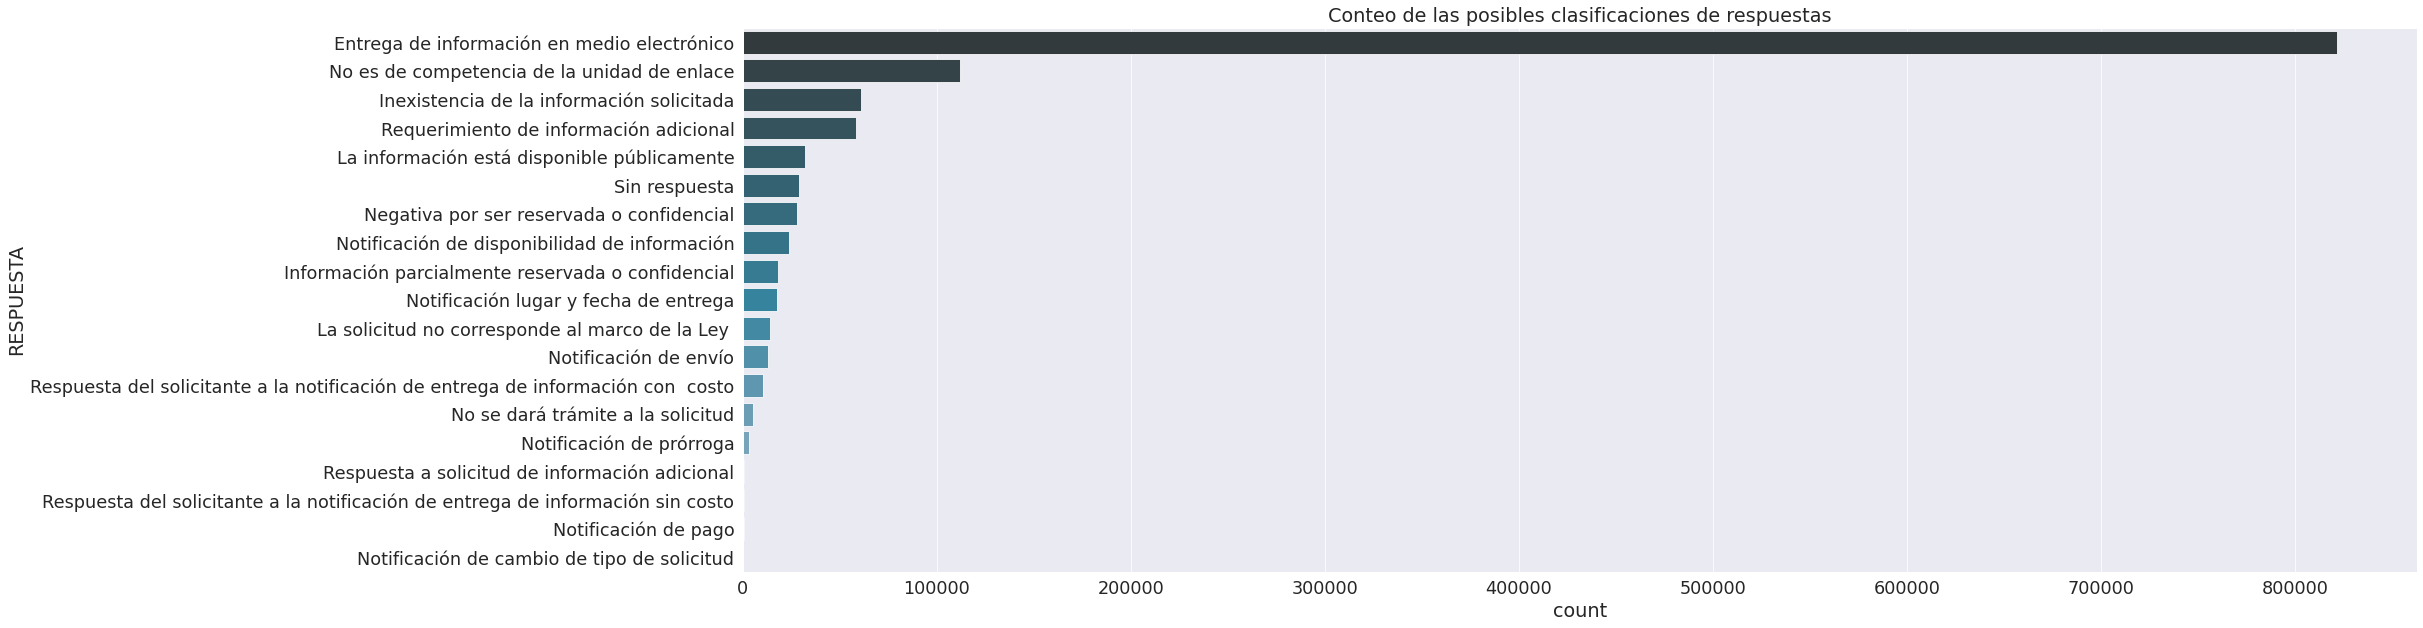

In [8]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(30, 10))
plt.title("Conteo de las posibles clasificaciones de respuestas")
ax = sns.countplot(y="RESPUESTA", data=df1,order = df1['RESPUESTA'].value_counts().index, palette="PuBuGn_d")

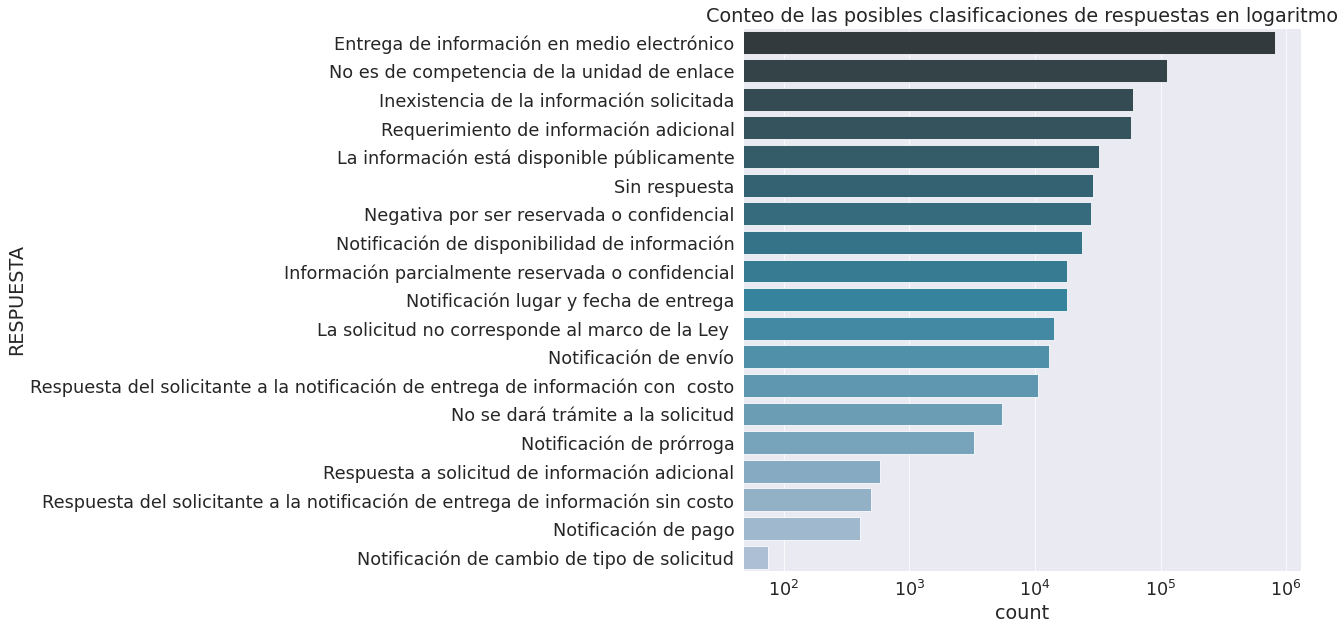

In [9]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Conteo de las posibles clasificaciones de respuestas en logaritmo")
ax = sns.countplot(y="RESPUESTA", data=df1,order = df1['RESPUESTA'].value_counts().index, palette="PuBuGn_d")
ax.set_xscale('log')

**Nota:** De esta clasificación podemos entender que existen básicamente 3 tipos de clasificaciones generales: *En proceso, Satisfactoria y No respondida o denegada.*

En números, la distribución de esta variable se ve de la siguiente manera:

In [10]:
num_por_tipos_df = eda.CreaTablaConteoPorcentaje(df1,'RESPUESTA', False)
num_por_tipos_df

,RESPUESTA,porcentaje
Entrega de información en medio electrónico,821499,65.74%
No es de competencia de la unidad de enlace,112107,8.97%
Inexistencia de la información solicitada,60685,4.86%
Requerimiento de información adicional,58464,4.68%
La información está disponible públicamente,32316,2.59%
Sin respuesta,28956,2.32%
Negativa por ser reservada o confidencial,28034,2.24%
Notificación de disponibilidad de información,23820,1.91%
Información parcialmente reservada o confidencial,18040,1.44%
Notificación lugar y fecha de entrega,17871,1.43%


Pero tomando en cuenta las categorías anteriormente mencionadas, sería de la siguiente forma:

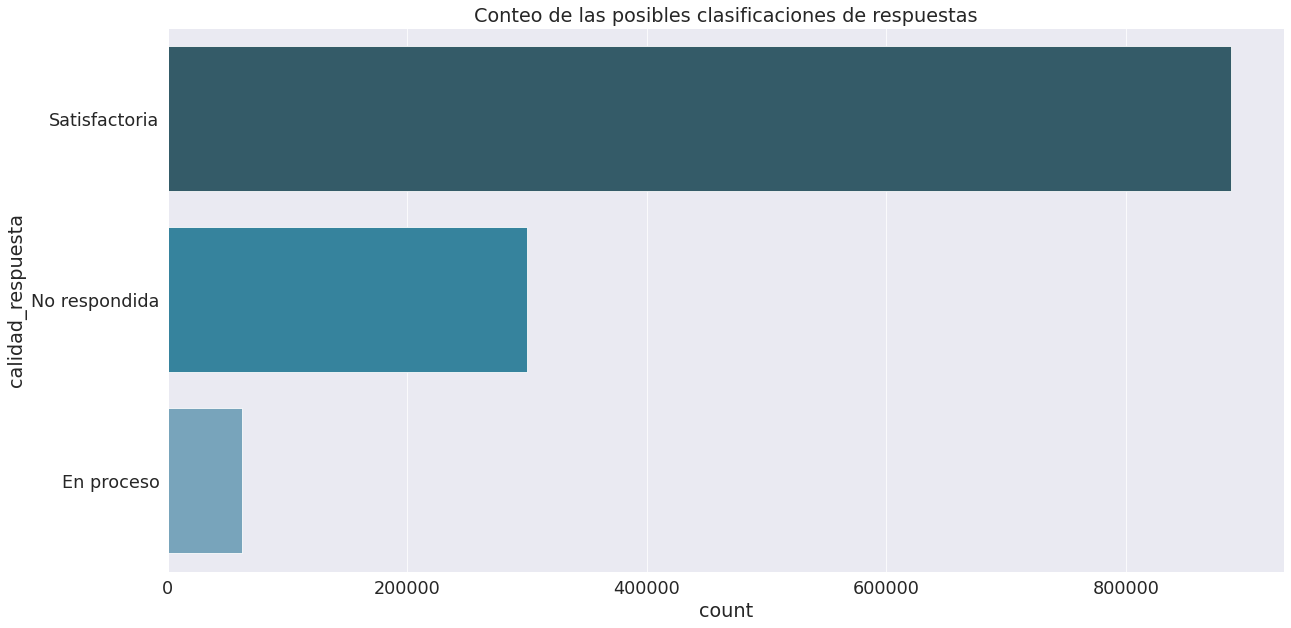

In [11]:
df_aux_respuesta = df.copy()
df_aux_respuesta = eda.UneCategoriaRespuestaString(df_aux_respuesta)
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(20, 10))
plt.title("Conteo de las posibles clasificaciones de respuestas")
ax = sns.countplot(y="calidad_respuesta", data=df_aux_respuesta,order = df_aux_respuesta['calidad_respuesta'].value_counts().index, palette="PuBuGn_d")

In [12]:
num_por_tipos_df_aux_respuesta = eda.CreaTablaConteoPorcentaje(df_aux_respuesta,'calidad_respuesta', False)
num_por_tipos_df_aux_respuesta

,calidad_respuesta,porcentaje
Satisfactoria,887615,71.03%
No respondida,299747,23.99%
En proceso,62306,4.99%


**Nota a tomar en cuenta para CLEANED:** Hay dos categorías que tienen errores o typos: 
* `Respuesta del solicitante a la notificación de entrega de información con  costo`
* `La solicitud no corresponde al marco de la Ley `

### Conociendo la variable `tipo_archivo_respuesta`

**Nota:** Por motivos del alcance de este análisis exploratorio, se considerarán principalmente las dos columnas creadas, mencionadas anteriormente.

¿Cuáles son los tipos de archivo que tenemos?

In [13]:
sorted(df1['tipo_archivo_respuesta'].unique().astype('str'))

['DOC',
 'None',
 'PDF',
 'Pdf',
 'XLS',
 'ZIP',
 'doc',
 'docx',
 'msg',
 'pdf',
 'rar',
 'txt',
 'xls',
 'xlsx',
 'zip']

Se puede notar que el algoritmo está marcando como diferentes las categorías en mayúsculas y minúsculas. Esto se tomará en cuenta para hacer la etapa del `Cleaned`. Por ahora, nos enfocaremos en la cantidad de casos como se encuentran en `RAW`.

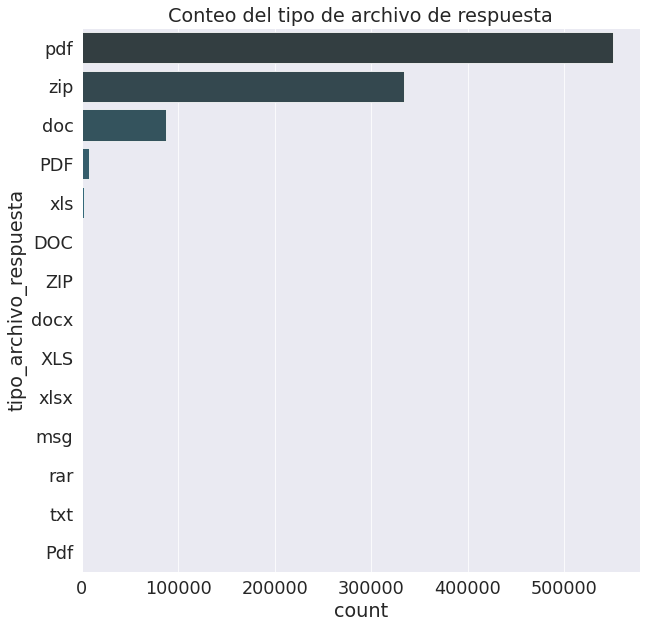

In [14]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Conteo del tipo de archivo de respuesta")
ax = sns.countplot(y="tipo_archivo_respuesta", data=df1,order = df1['tipo_archivo_respuesta'].value_counts().index, palette="PuBuGn_d")

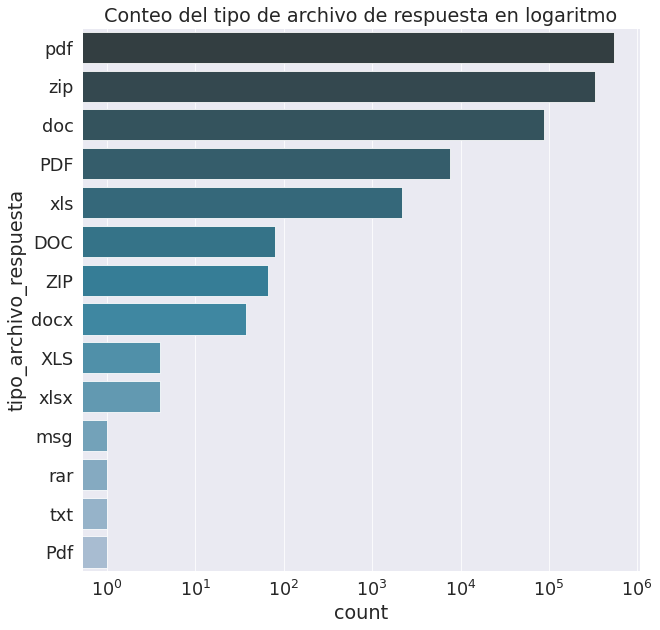

In [15]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Conteo del tipo de archivo de respuesta en logaritmo")
ax = sns.countplot(y="tipo_archivo_respuesta", data=df1,order = df1['tipo_archivo_respuesta'].value_counts().index, palette="PuBuGn_d")
ax.set_xscale('log')

Para verlo más claramente, observaremos las cantidades que esto significa.

In [16]:
num_por_tipos_df = eda.CreaTablaConteoPorcentaje(df1, 'tipo_archivo_respuesta', False)
num_por_tipos_df

,tipo_archivo_respuesta,porcentaje
pdf,550781,44.07%
zip,334303,26.75%
NaN,266874,21.36%
doc,87832,7.03%
PDF,7531,0.6%
xls,2152,0.17%
DOC,79,0.01%
ZIP,67,0.01%
docx,37,0.0%
XLS,4,0.0%


Por motivos de este análisis, unificaremos los tipos de archivo en minúsculas, para tener los datos mejor identificados.

In [17]:
df_aux_otro = eda.UnificaTipodeArchivo(df1)

#### Tipo de archivo unificado:

Ya unificando los datos, se tiene la siguiente distribución.

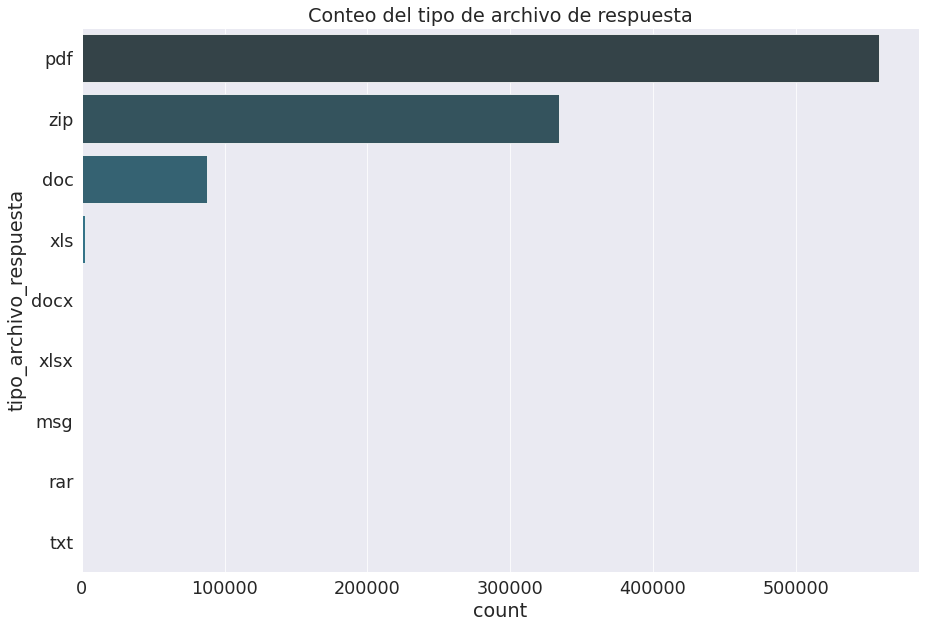

In [18]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(15, 10))
plt.title("Conteo del tipo de archivo de respuesta")
ax = sns.countplot(y="tipo_archivo_respuesta", data=df_aux_otro,order = df_aux_otro['tipo_archivo_respuesta'].value_counts().index, palette="PuBuGn_d")

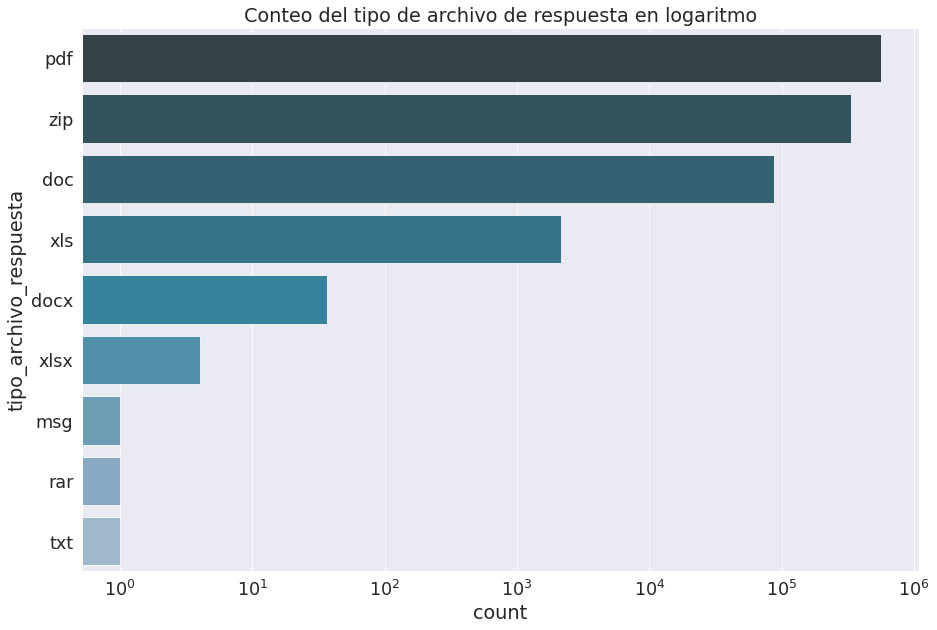

In [19]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(15, 10))
plt.title("Conteo del tipo de archivo de respuesta en logaritmo")
ax = sns.countplot(y="tipo_archivo_respuesta", data=df_aux_otro,order = df_aux_otro['tipo_archivo_respuesta'].value_counts().index, palette="PuBuGn_d")
ax.set_xscale('log')

En números:

In [20]:
num_por_tipos_df = eda.CreaTablaConteoPorcentaje(df_aux_otro, 'tipo_archivo_respuesta', False)
num_por_tipos_df

,tipo_archivo_respuesta,porcentaje
pdf,558313,44.68%
zip,334370,26.76%
NaN,266874,21.36%
doc,87911,7.03%
xls,2156,0.17%
docx,37,0.0%
xlsx,4,0.0%
msg,1,0.0%
rar,1,0.0%
txt,1,0.0%


### Variable `RESPUESTA` y variable `tipo_archivo_respuesta`

In [21]:
sorted(df_aux_otro['RESPUESTA'].unique().astype('str'))

['Entrega de información en medio electrónico',
 'Inexistencia de la información solicitada',
 'Información parcialmente reservada o confidencial',
 'La información está disponible públicamente',
 'La solicitud no corresponde al marco de la Ley ',
 'Negativa por ser reservada o confidencial',
 'No es de competencia de la unidad de enlace',
 'No se dará trámite a la solicitud',
 'Notificación de cambio de tipo de solicitud',
 'Notificación de disponibilidad de información',
 'Notificación de envío',
 'Notificación de pago',
 'Notificación de prórroga',
 'Notificación lugar y fecha de entrega',
 'Requerimiento de información adicional',
 'Respuesta a solicitud de información adicional',
 'Respuesta del solicitante a la notificación de entrega de información con  costo',
 'Respuesta del solicitante a la notificación de entrega de información sin costo',
 'Sin respuesta']

In [22]:
df_orig = df.copy()
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo_orig = df_orig.groupby('RESPUESTA')['tipo_archivo_respuesta'].value_counts(dropna=False)
print("Tabla que indica el número de tipos de archivo por cada elemento de la variable `RESPUESTA` sobre el data frame original")
pd.DataFrame(respuesta_vs_tipo_archivo_orig)

Tabla que indica el número de tipos de archivo por cada elemento de la variable `RESPUESTA` sobre el data frame original


tipo_archivo_respuesta
RESPUESTA                                          tipo_archivo_respuesta                        
Entrega de información en medio electrónico        pdf                                     435814
                                                   zip                                     294608
                                                   doc                                      64098
                                                   NaN                                      18954
                                                   PDF                                       5843
                                                   xls                                       2087
                                                   ZIP                                         61
                                                   DOC                                         29
                                                   XLS                                          3
                                                   msg                                          1
                                                   rar                                          1
Inexistencia de la información solicitada          pdf                                      41939
                                                   zip                                      11014
                                                   doc                                       5292
                                                   NaN                                       1921
                                                   PDF                                        513
                                                   xls                                          3
                                                   DOC                                          2
                                                   txt                                          1
Información parcialmente reservada o confidencial  zip                                       9483
                                                   pdf                                       5904
                                                   NaN                                       2327
                                                   doc                                        287
                                                   PDF                                         35
                                                   ZIP                                          2
                                                   xls                                          2
La información está disponible públicamente        pdf                                      15519
                                                   doc                                       6116
                                                   NaN                                       5346
                                                   zip                                       4887
                                                   PDF                                        355
                                                   xls                                         51
                                                   DOC                                         38
                                                   ZIP                                          2
                                                   Pdf                                          1
                                                   XLS                                          1
La solicitud no corresponde al marco de la Ley     NaN                                       6368
                                                   pdf                                       5742
                                                   doc                                       1592
                                                   zip   

In [23]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df_aux_otro.groupby('RESPUESTA')['tipo_archivo_respuesta'].value_counts(dropna=False)
print("Tabla que indica el número de tipos de archivo por cada elemento de la variable `RESPUESTA` sobre el data frame que tiene la variable 'tipo_archivo_respuesta' unificada")
pd.DataFrame(respuesta_vs_tipo_archivo)

Tabla que indica el número de tipos de archivo por cada elemento de la variable `RESPUESTA` sobre el data frame que tiene la variable 'tipo_archivo_respuesta' unificada


tipo_archivo_respuesta
RESPUESTA                                          tipo_archivo_respuesta                        
Entrega de información en medio electrónico        pdf                                     441657
                                                   zip                                     294669
                                                   doc                                      64127
                                                   NaN                                      18954
                                                   xls                                       2090
                                                   msg                                          1
                                                   rar                                          1
Inexistencia de la información solicitada          pdf                                      42452
                                                   zip                                      11014
                                                   doc                                       5294
                                                   NaN                                       1921
                                                   xls                                          3
                                                   txt                                          1
Información parcialmente reservada o confidencial  zip                                       9485
                                                   pdf                                       5939
                                                   NaN                                       2327
                                                   doc                                        287
                                                   xls                                          2
La información está disponible públicamente        pdf                                      15875
                                                   doc                                       6154
                                                   NaN                                       5346
                                                   zip                                       4889
                                                   xls                                         52
La solicitud no corresponde al marco de la Ley     NaN                                       6368
                                                   pdf                                       5842
                                                   doc                                       1592
                                                   zip                                        304
                                                   xls                                          3
Negativa por ser reservada o confidencial          pdf                                      13010
                                                   zip                                      10499
                                                   doc                                       3846
                                                   NaN                                        679
No es de competencia de la unidad de enlace        NaN                                     111321
                                                   pdf                                        580
                                                   zip                                        150
                                                   doc                                         56
No se dará trámite a la solicitud                  NaN                                       3185
                                                   pdf                                       1631
                                                   zip                                        417
                                                   doc   

/home/rafaelortega/.pyenv/versions/3.8.2/lib/python3.8/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


<Figure size 8640x2880 with 0 Axes>

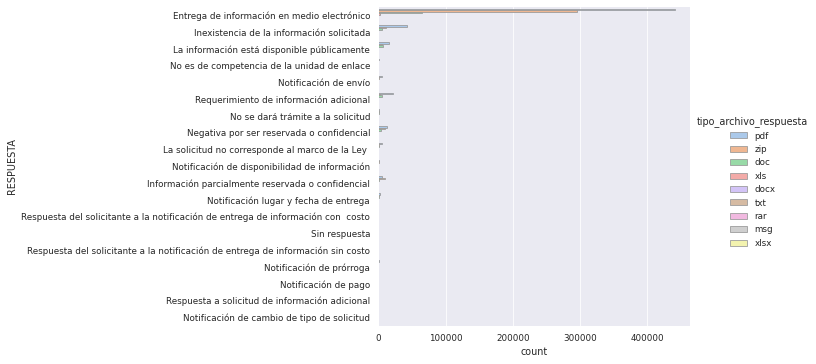

In [24]:
sns.set_context("paper", font_scale=1)
plt.figure(figsize=(120, 40))
ax = sns.catplot(y="RESPUESTA", hue="tipo_archivo_respuesta", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_aux_otro);
#ax.set_xscale('log')

Cuando el adjunto es un ZIP, ¿cuál es la distribución de las cantidades de archivos que están contenidos en él?

In [25]:
num_por_tipos = df_aux_otro[df_aux_otro.tipo_archivo_respuesta == 'zip']
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
#num_por_tipos_df.head()

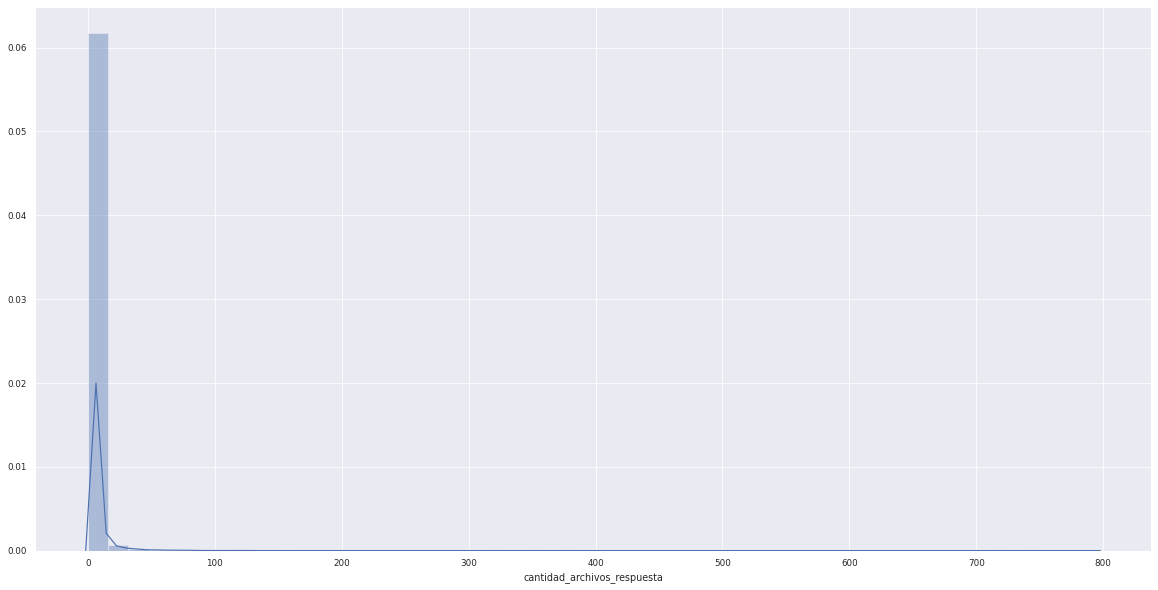

In [26]:
plt.figure(figsize=(20, 10))
sns.distplot(num_por_tipos_df['cantidad_archivos_respuesta']); 

In [27]:
resp = df[df.tipo_archivo_respuesta == 'zip']
resp_num_zip = resp['cantidad_archivos_respuesta'].value_counts(dropna=True)
resp_num_zip
resp_num_zip_df = pd.DataFrame(data=resp_num_zip)
#resp_num_zip_df['porcentaje'] = resp_num_zip_df['cantidad_archivos_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
resp_num_zip_df.sort_index(axis=0)


,cantidad_archivos_respuesta
0.0,19
1.0,33557
2.0,171400
3.0,61981
4.0,24991
5.0,12367
6.0,6965
7.0,5485
8.0,3028
9.0,2350


Tenemos algunos archivos con extensión .zip que contienen cantidades de archivos en su contenido mayores a 30.

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 <a list of 10 Text major ticklabel objects>)

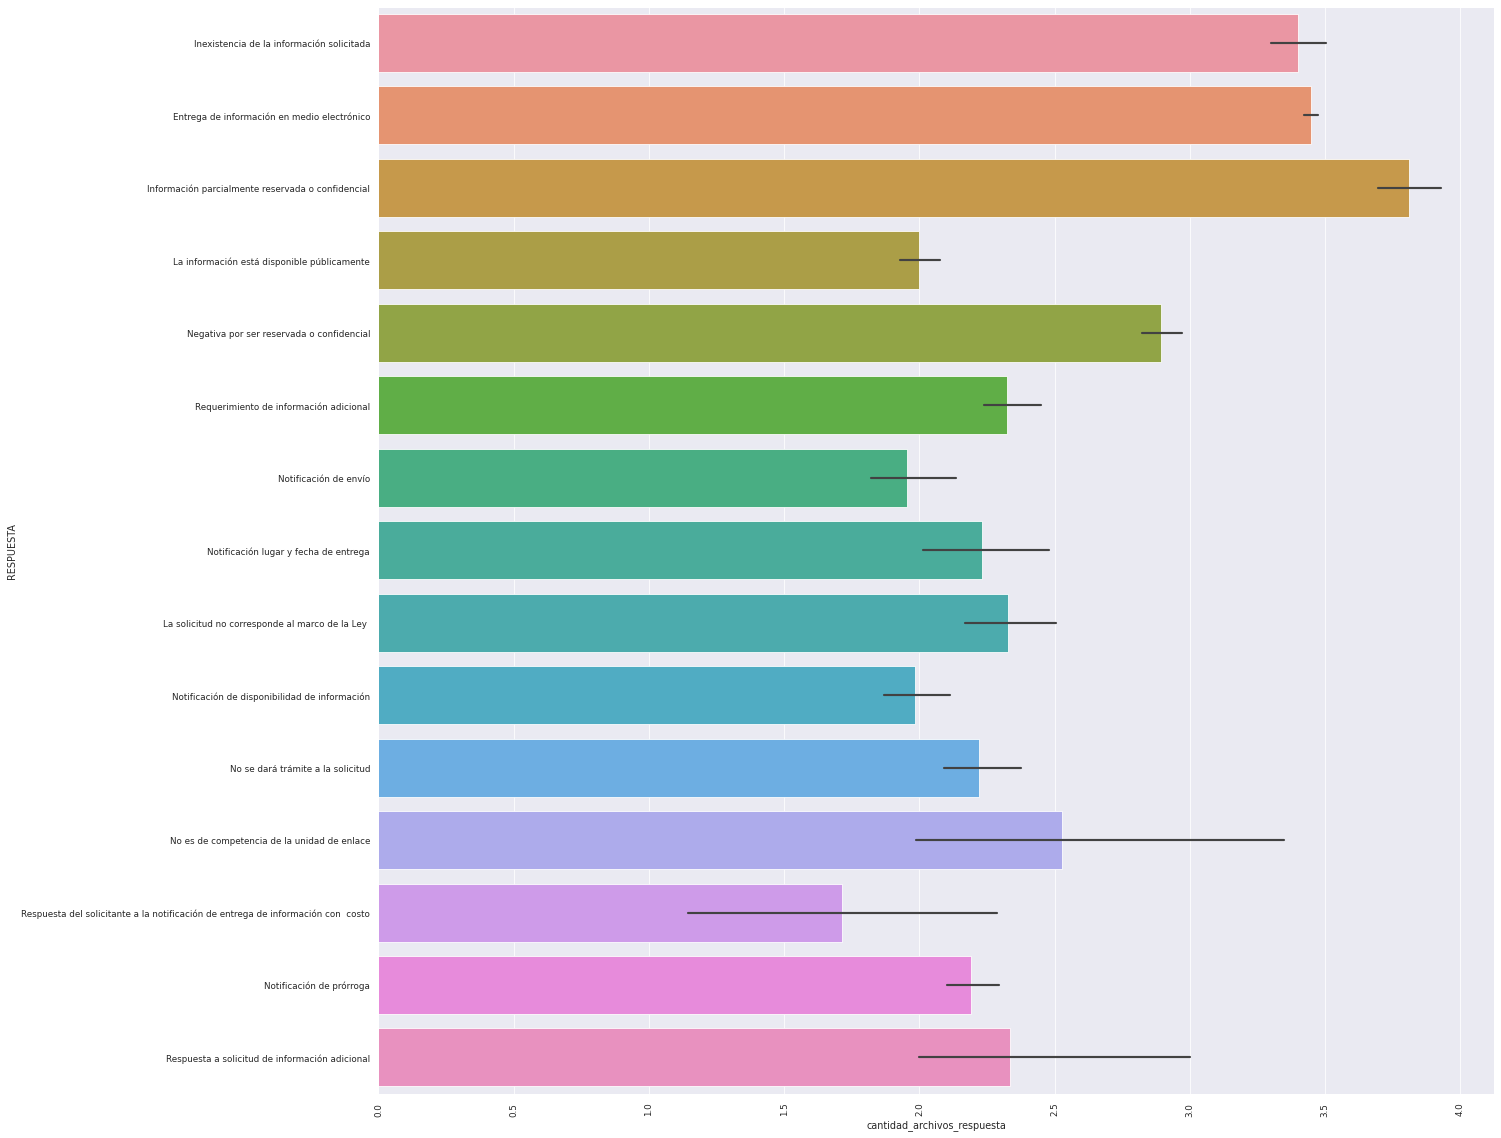

In [28]:
plt.figure(figsize = (20, 20))
#ax = sns.barplot(x='RESPUESTA', y='cantidad_archivos_respuesta', data=num_por_tipos_df)
ax = sns.barplot(x='cantidad_archivos_respuesta', y='RESPUESTA', data=num_por_tipos_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=90)
#g = sns.FacetGrid(num_por_tipos_df)
#g.map(plt.hist, "cantidad_archivos_respuesta");

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 <a list of 9 Text major ticklabel objects>)

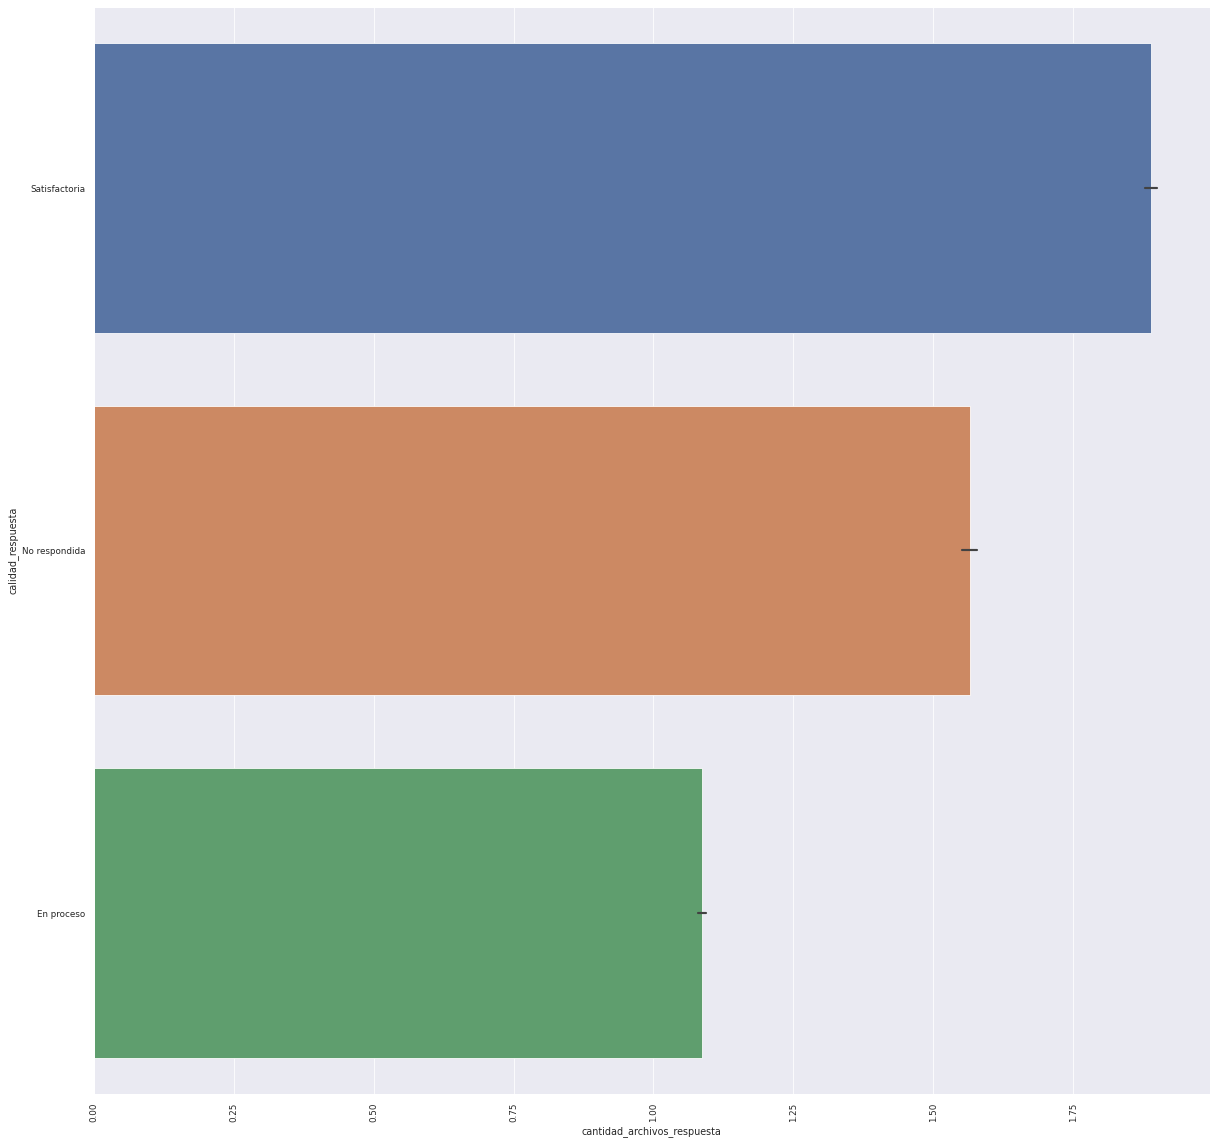

In [29]:
plt.figure(figsize = (20, 20))
#ax = sns.barplot(x='RESPUESTA', y='cantidad_archivos_respuesta', data=num_por_tipos_df)
ax = sns.barplot(x='cantidad_archivos_respuesta', y='calidad_respuesta', data=df_aux_respuesta)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=90)
#g = sns.FacetGrid(num_por_tipos_df)
#g.map(plt.hist, "cantidad_archivos_respuesta");

In [30]:
respuesta_vs_tipo_archivo = df_aux_otro.groupby('tipo_archivo_respuesta')['cantidad_archivos_respuesta'].sum()
respuesta_vs_tipo_archivo

tipo_archivo_respuesta
doc       87911.0
docx         37.0
msg           1.0
pdf      558313.0
rar           1.0
txt           1.0
xls        2156.0
xlsx          4.0
zip     1138152.0
Name: cantidad_archivos_respuesta, dtype: float64

In [31]:
resp_num_zip = pd.DataFrame(columns = ['cantidad_archivos_respuesta','numero'], data= resp_num_zip)#, ignore_index=True)
resp_num_zip.head()

,cantidad_archivos_respuesta,numero
2.0,171400,NaN
3.0,61981,NaN
1.0,33557,NaN
4.0,24991,NaN
5.0,12367,NaN


In [32]:
resp_num_zip[:0].describe()

,cantidad_archivos_respuesta
count,66.000000
mean,5057.075758
std,22714.852850
min,19.000000
25%,37.250000
50%,93.500000
75%,435.500000
max,171400.000000


In [33]:
resp_num_zip_df.sort_index(axis=0)

,cantidad_archivos_respuesta
0.0,19
1.0,33557
2.0,171400
3.0,61981
4.0,24991
5.0,12367
6.0,6965
7.0,5485
8.0,3028
9.0,2350


¿De cuales tipos de archivo podemos explorar su contenido?

Por motivos de este análisis, se extraerán solamente los textos que se encuentran en formato pdf.

¿Qué tipos de archivo y qué cantidades de archivos podemos decir que tienen una respuesta real?

Esta parte se revisará más adelante, pues se necesita importar el texto de los documentos.

## #19: Definición final de variable "calidad_respuesta" y "calidad_respuesta_real"

En el notebook eda.ipynb de la iteración 1 de este proyecto hay una sección titulada "Calidad de Respuesta", que asigna a cada uno de los 13 tipos de respuesta un score de $1$ para positivo, $0$ para neutro, y $-1$ para negativo.

Se debe evaluar esta taxonomía y discutir entre todo el equipo si se usará, se descartará en favor de la actual propuesta por **@rafaelortegar** , o se desarrollará una combinación.

In [34]:
df = original.copy()
df.head()

,FOLIO,FECHASOLICITUD,DEPENDENCIA,ESTATUS,MEDIOENTRADA,TIPOSOLICITUD,DESCRIPCIONSOLICITUD,OTROSDATOS,ARCHIVOADJUNTOSOLICITUD,MEDIOENTREGA,...,ARCHIVORESPUESTA,FECHARESPUESTA,PAIS,ESTADO,MUNICIPIO,CODIGOPOSTAL,SECTOR,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto
0,1857500001912,2012/01/01 05:04:07,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Copia de los documentos y los datos con que cu...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...
1,1857500002012,2012/01/01 05:13:16,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Del ATG para precisar información y datos usa...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...
2,0001800000712,2012/01/01 09:46:39,SECRETARÍA DE ENERGÍA,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Energía,zip,2.0,None
3,0000600003712,2012/01/01 10:11:41,SECRETARÍA DE HACIENDA Y CRÉDITO PÚBLICO,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Hacienda y Crédito Público,pdf,1.0,INIDOS SECRETARIA DE HACIENDA Y CREDITO PUBLI...
4,0001500002812,2012/01/01 10:32:15,SECRETARÍA DE DESARROLLO AGRARIO TERRITORIAL ...,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/02/01,México,Distrito Federal,MIGUEL HIDALGO,11230,Reforma Agraria,zip,4.0,None


In [35]:
labels = df.RESPUESTA.unique().astype(str)
labels

array(['Entrega de información en medio electrónico',
       'Inexistencia de la información solicitada',
       'La información está disponible públicamente',
       'No es de competencia de la unidad de enlace',
       'Notificación de envío', 'Requerimiento de información adicional',
       'No se dará trámite a la solicitud',
       'Negativa por ser reservada o confidencial',
       'La solicitud no corresponde al marco de la Ley ',
       'Notificación de disponibilidad de información',
       'Información parcialmente reservada o confidencial',
       'Notificación lugar y fecha de entrega',
       'Respuesta del solicitante a la notificación de entrega de información con  costo',
       'Sin respuesta',
       'Respuesta del solicitante a la notificación de entrega de información sin costo',
       'Notificación de prórroga', 'Notificación de pago',
       'Respuesta a solicitud de información adicional',
       'Notificación de cambio de tipo de solicitud'], dtype='<U80')

### Categorización de la iteración 1

In [36]:
categorias = [0, 1, 0, 1, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1, -1, 1, 1, 1, -1]
category_translation = dict(zip(labels, categorias))

In [37]:
df['calidad_respuesta_anterior'] = df.RESPUESTA.map(category_translation)

### Categorización propuesta por **@rafaelortegar**:

In [38]:
df = eda.UneCategoriaRespuestaString(df)

In [39]:
df.columns

Index(['FOLIO', 'FECHASOLICITUD', 'DEPENDENCIA', 'ESTATUS', 'MEDIOENTRADA',
       'TIPOSOLICITUD', 'DESCRIPCIONSOLICITUD', 'OTROSDATOS',
       'ARCHIVOADJUNTOSOLICITUD', 'MEDIOENTREGA', 'FECHALIMITE', 'RESPUESTA',
       'TEXTORESPUESTA', 'ARCHIVORESPUESTA', 'FECHARESPUESTA', 'PAIS',
       'ESTADO', 'MUNICIPIO', 'CODIGOPOSTAL', 'SECTOR',
       'tipo_archivo_respuesta', 'cantidad_archivos_respuesta',
       'texto_respuesta_adjunto', 'calidad_respuesta_anterior',
       'calidad_respuesta'],
      dtype='object')

## Preparación del Data Frame para comparación

In [40]:
# Extraemos primero ambas columnas referentes a la respuesta
df_comparacion = df[['RESPUESTA','calidad_respuesta','calidad_respuesta_anterior']]

# Quitamos los valores duplicados, de modo que nos queden solamente una categoría de cada valor
df_comparacion.drop_duplicates(subset='RESPUESTA', keep='first', inplace=True)

# quedan los valores con un index, el cual se reiniciará
df_comparacion = df_comparacion.reset_index()

# Imprimiendo el data set resultado.
pd.set_option("display.max_colwidth", 1000) # Opción para expandir las columnas del df
df_comparacion = df_comparacion[['RESPUESTA','calidad_respuesta','calidad_respuesta_anterior']]
#df_comparacion



<ipython-input-40-76b3a425b65c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comparacion.drop_duplicates(subset='RESPUESTA', keep='first', inplace=True)


### ¿Cómo están asignadas las categorías?

#### calidad_respuesta:

In [41]:
df_comparacion[['RESPUESTA','calidad_respuesta_anterior']]

,RESPUESTA,calidad_respuesta_anterior
0,Entrega de información en medio electrónico,0
1,Inexistencia de la información solicitada,1
2,La información está disponible públicamente,0
3,No es de competencia de la unidad de enlace,1
4,Notificación de envío,-1
5,Requerimiento de información adicional,0
6,No se dará trámite a la solicitud,0
7,Negativa por ser reservada o confidencial,0
8,La solicitud no corresponde al marco de la Ley,0
9,Notificación de disponibilidad de información,-1


In [42]:
num_por_categ = df['calidad_respuesta_anterior'].value_counts(dropna=False)
#num_por_tipos
num_por_categ_df = pd.DataFrame(data=num_por_categ)
num_por_categ_df['porcentaje'] = df['calidad_respuesta_anterior'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_categ_df

,calidad_respuesta_anterior,porcentaje
0,1006329,80.53%
1,177039,14.17%
-1,66300,5.31%


#### calidad_respuesta_rafa:

In [43]:
df_comparacion[['RESPUESTA','calidad_respuesta']]

,RESPUESTA,calidad_respuesta
0,Entrega de información en medio electrónico,Satisfactoria
1,Inexistencia de la información solicitada,No respondida
2,La información está disponible públicamente,No respondida
3,No es de competencia de la unidad de enlace,No respondida
4,Notificación de envío,Satisfactoria
5,Requerimiento de información adicional,En proceso
6,No se dará trámite a la solicitud,No respondida
7,Negativa por ser reservada o confidencial,No respondida
8,La solicitud no corresponde al marco de la Ley,No respondida
9,Notificación de disponibilidad de información,Satisfactoria


In [44]:
num_por_categ = df['calidad_respuesta'].value_counts(dropna=False)
#num_por_tipos
num_por_categ_df = pd.DataFrame(data=num_por_categ)
num_por_categ_df['porcentaje'] = df['calidad_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_categ_df

,calidad_respuesta,porcentaje
Satisfactoria,887615,71.03%
No respondida,299747,23.99%
En proceso,62306,4.99%


## Comparación

Conjuntamente, se ven de la siguiente manera:

In [45]:
df_comparacion

,RESPUESTA,calidad_respuesta,calidad_respuesta_anterior
0,Entrega de información en medio electrónico,Satisfactoria,0
1,Inexistencia de la información solicitada,No respondida,1
2,La información está disponible públicamente,No respondida,0
3,No es de competencia de la unidad de enlace,No respondida,1
4,Notificación de envío,Satisfactoria,-1
5,Requerimiento de información adicional,En proceso,0
6,No se dará trámite a la solicitud,No respondida,0
7,Negativa por ser reservada o confidencial,No respondida,0
8,La solicitud no corresponde al marco de la Ley,No respondida,0
9,Notificación de disponibilidad de información,Satisfactoria,-1


Algunas categorías no están correctamente asignadas.

### Algunas categorias por tipo archivo_respuesta

In [46]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['tipo_archivo_respuesta'].value_counts(dropna=False)
#respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['tipo_archivo_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
#num_por_categ_df = pd.DataFrame(data=respuesta_vs_tipo_archivo)
#num_por_categ_df['porcentaje'] = respuesta_vs_tipo_archivo['calidad_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

tipo_archivo_respuesta
calidad_respuesta_anterior tipo_archivo_respuesta                        
-1                         NaN                                      58788
                           pdf                                       6492
                           zip                                        729
                           doc                                        237
                           PDF                                         54
 0                         pdf                                     500847
                           zip                                     322243
                           NaN                                      91756
                           doc                                      82229
                           PDF                                       6952
                           xls                                       2149
                           DOC                                         77
                           ZIP                                         67
                           XLS                                          4
                           Pdf                                          1
                           docx                                         1
                           msg                                          1
                           rar                                          1
                           xlsx                                         1
 1                         NaN                                     116330
                           pdf                                      43442
                           zip                                      11331
                           doc                                       5366
                           PDF                                        525
                           docx                                        36
                           xls                                          3
                           xlsx                                         3
                           DOC                                          2
                           txt                                          1

In [47]:
pd.set_option('display.max_rows', None)
#respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['tipo_archivo_respuesta'].value_counts(dropna=False)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['tipo_archivo_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
#num_por_categ_df = pd.DataFrame(data=respuesta_vs_tipo_archivo)
#num_por_categ_df['porcentaje'] = respuesta_vs_tipo_archivo['calidad_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

tipo_archivo_respuesta
calidad_respuesta_anterior tipo_archivo_respuesta                       
-1                         NaN                                    88.67%
                           pdf                                     9.79%
                           zip                                      1.1%
                           doc                                     0.36%
                           PDF                                     0.08%
 0                         pdf                                    49.77%
                           zip                                    32.02%
                           NaN                                     9.12%
                           doc                                     8.17%
                           PDF                                     0.69%
                           xls                                     0.21%
                           DOC                                     0.01%
                           ZIP                                     0.01%
                           XLS                                      0.0%
                           Pdf                                      0.0%
                           docx                                     0.0%
                           msg                                      0.0%
                           rar                                      0.0%
                           xlsx                                     0.0%
 1                         NaN                                    65.71%
                           pdf                                    24.54%
                           zip                                      6.4%
                           doc                                     3.03%
                           PDF                                      0.3%
                           docx                                    0.02%
                           xls                                      0.0%
                           xlsx                                     0.0%
                           DOC                                      0.0%
                           txt                                      0.0%

In [48]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['tipo_archivo_respuesta'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

tipo_archivo_respuesta
calidad_respuesta tipo_archivo_respuesta                        
En proceso        NaN                                      31835
                  pdf                                      22609
                  doc                                       5533
                  zip                                       2004
                  PDF                                        278
                  docx                                        37
                  xls                                          4
                  xlsx                                         4
                  DOC                                          2
No respondida     NaN                                     160103
                  pdf                                      83989
                  zip                                      36752
                  doc                                      17447
                  PDF                                       1339
                  xls                                         60
                  DOC                                         48
                  ZIP                                          6
                  Pdf                                          1
                  XLS                                          1
                  txt                                          1
Satisfactoria     pdf                                     444183
                  zip                                     295547
                  NaN                                      74936
                  doc                                      64852
                  PDF                                       5914
                  xls                                       2088
                  ZIP                                         61
                  DOC                                         29
                  XLS                                          3
                  msg                                          1
                  rar                                          1

In [49]:
pd.set_option('display.max_rows', None)
#respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['tipo_archivo_respuesta'].value_counts(dropna=False)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['tipo_archivo_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
#num_por_categ_df = pd.DataFrame(data=respuesta_vs_tipo_archivo)
#num_por_categ_df['porcentaje'] = respuesta_vs_tipo_archivo['calidad_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

tipo_archivo_respuesta
calidad_respuesta tipo_archivo_respuesta                       
En proceso        NaN                                    51.09%
                  pdf                                    36.29%
                  doc                                     8.88%
                  zip                                     3.22%
                  PDF                                     0.45%
                  docx                                    0.06%
                  xls                                     0.01%
                  xlsx                                    0.01%
                  DOC                                      0.0%
No respondida     NaN                                    53.41%
                  pdf                                    28.02%
                  zip                                    12.26%
                  doc                                     5.82%
                  PDF                                     0.45%
                  xls                                     0.02%
                  DOC                                     0.02%
                  ZIP                                      0.0%
                  Pdf                                      0.0%
                  XLS                                      0.0%
                  txt                                      0.0%
Satisfactoria     pdf                                    50.04%
                  zip                                     33.3%
                  NaN                                     8.44%
                  doc                                     7.31%
                  PDF                                     0.67%
                  xls                                     0.24%
                  ZIP                                     0.01%
                  DOC                                      0.0%
                  XLS                                      0.0%
                  msg                                      0.0%
                  rar                                      0.0%

### Algunas categorias por Estatus

In [50]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['ESTATUS'].value_counts(dropna=False)
#respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['ESTATUS'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
#num_por_categ_df = pd.DataFrame(data=respuesta_vs_tipo_archivo)
#num_por_categ_df['porcentaje'] = respuesta_vs_tipo_archivo['calidad_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

ESTATUS
calidad_respuesta_anterior ESTATUS                                                
-1                         En proceso                                        29029
                           Desechada por falta de respuesta del ciudadano    20839
                           Terminada                                         12955
                           En espera de forma de entrega                      2981
                           En proceso de entrega de información                494
                           En proceso- información adicional                     2
 0                         Terminada                                        919329
                           Desechada por falta de respuesta del ciudadano    73133
                           Desechada por falta de pago                        9270
                           En espera de forma de entrega                      2476
                           En espera de pago                                  1224
                           En espera de ampliación de información              897
 1                         Terminada                                        172792
                           En proceso con prórroga                            3260
                           En proceso- información adicional                   581
                           Con pago realizado                                  405
                           Desechada por falta de respuesta del ciudadano        1

In [51]:
pd.set_option('display.max_rows', None)
#respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['ESTATUS'].value_counts(dropna=False)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['ESTATUS'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
#num_por_categ_df = pd.DataFrame(data=respuesta_vs_tipo_archivo)
#num_por_categ_df['porcentaje'] = respuesta_vs_tipo_archivo['calidad_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

ESTATUS
calidad_respuesta_anterior ESTATUS                                               
-1                         En proceso                                      43.78%
                           Desechada por falta de respuesta del ciudadano  31.43%
                           Terminada                                       19.54%
                           En espera de forma de entrega                     4.5%
                           En proceso de entrega de información             0.75%
                           En proceso- información adicional                 0.0%
 0                         Terminada                                       91.35%
                           Desechada por falta de respuesta del ciudadano   7.27%
                           Desechada por falta de pago                      0.92%
                           En espera de forma de entrega                    0.25%
                           En espera de pago                                0.12%
                           En espera de ampliación de información           0.09%
 1                         Terminada                                        97.6%
                           En proceso con prórroga                          1.84%
                           En proceso- información adicional                0.33%
                           Con pago realizado                               0.23%
                           Desechada por falta de respuesta del ciudadano    0.0%

In [52]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['ESTATUS'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

ESTATUS
calidad_respuesta ESTATUS                                                
En proceso        Desechada por falta de respuesta del ciudadano    57568
                  En proceso con prórroga                            3260
                  En espera de ampliación de información              897
                  En proceso- información adicional                   581
No respondida     Terminada                                        252751
                  En proceso                                        28956
                  Desechada por falta de respuesta del ciudadano    15564
                  En espera de forma de entrega                      2476
Satisfactoria     Terminada                                        852325
                  Desechada por falta de respuesta del ciudadano    20841
                  Desechada por falta de pago                        9270
                  En espera de forma de entrega                      2981
                  En espera de pago                                  1224
                  En proceso de entrega de información                494
                  Con pago realizado                                  405
                  En proceso                                           73
                  En proceso- información adicional                     2

In [53]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['ESTATUS'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
pd.DataFrame(respuesta_vs_tipo_archivo)

ESTATUS
calidad_respuesta ESTATUS                                               
En proceso        Desechada por falta de respuesta del ciudadano   92.4%
                  En proceso con prórroga                          5.23%
                  En espera de ampliación de información           1.44%
                  En proceso- información adicional                0.93%
No respondida     Terminada                                       84.32%
                  En proceso                                       9.66%
                  Desechada por falta de respuesta del ciudadano   5.19%
                  En espera de forma de entrega                    0.83%
Satisfactoria     Terminada                                       96.02%
                  Desechada por falta de respuesta del ciudadano   2.35%
                  Desechada por falta de pago                      1.04%
                  En espera de forma de entrega                    0.34%
                  En espera de pago                                0.14%
                  En proceso de entrega de información             0.06%
                  Con pago realizado                               0.05%
                  En proceso                                       0.01%
                  En proceso- información adicional                 0.0%

### Algunas categorias por `RESPUESTA`

In [54]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['RESPUESTA'].value_counts(dropna=False)
#respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['ESTATUS'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
#num_por_categ_df = pd.DataFrame(data=respuesta_vs_tipo_archivo)
#num_por_categ_df['porcentaje'] = respuesta_vs_tipo_archivo['calidad_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

RESPUESTA
calidad_respuesta_anterior RESPUESTA                                                                                  
-1                         Sin respuesta                                                                         28956
                           Notificación de disponibilidad de información                                         23820
                           Notificación de envío                                                                 12955
                           Respuesta del solicitante a la notificación de entrega de información sin costo         494
                           Notificación de cambio de tipo de solicitud                                              75
 0                         Entrega de información en medio electrónico                                          821499
                           Requerimiento de información adicional                                                58464
                           La información está disponible públicamente                                           32316
                           Negativa por ser reservada o confidencial                                             28034
                           Información parcialmente reservada o confidencial                                     18040
                           Notificación lugar y fecha de entrega                                                 17871
                           La solicitud no corresponde al marco de la Ley                                        14109
                           Respuesta del solicitante a la notificación de entrega de información con  costo      10496
                           No se dará trámite a la solicitud                                                      5500
 1                         No es de competencia de la unidad de enlace                                          112107
                           Inexistencia de la información solicitada                                             60685
                           Notificación de prórroga                                                               3260
                           Respuesta a solicitud de información adicional                                          582
                           Notificación de pago                                                                    405

In [55]:
pd.set_option('display.max_rows', None)
#respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['ESTATUS'].value_counts(dropna=False)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['RESPUESTA'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
#num_por_categ_df = pd.DataFrame(data=respuesta_vs_tipo_archivo)
#num_por_categ_df['porcentaje'] = respuesta_vs_tipo_archivo['calidad_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

RESPUESTA
calidad_respuesta_anterior RESPUESTA                                                                                 
-1                         Sin respuesta                                                                       43.67%
                           Notificación de disponibilidad de información                                       35.93%
                           Notificación de envío                                                               19.54%
                           Respuesta del solicitante a la notificación de entrega de información sin costo      0.75%
                           Notificación de cambio de tipo de solicitud                                          0.11%
 0                         Entrega de información en medio electrónico                                         81.63%
                           Requerimiento de información adicional                                               5.81%
                           La información está disponible públicamente                                          3.21%
                           Negativa por ser reservada o confidencial                                            2.79%
                           Información parcialmente reservada o confidencial                                    1.79%
                           Notificación lugar y fecha de entrega                                                1.78%
                           La solicitud no corresponde al marco de la Ley                                        1.4%
                           Respuesta del solicitante a la notificación de entrega de información con  costo     1.04%
                           No se dará trámite a la solicitud                                                    0.55%
 1                         No es de competencia de la unidad de enlace                                         63.32%
                           Inexistencia de la información solicitada                                           34.28%
                           Notificación de prórroga                                                             1.84%
                           Respuesta a solicitud de información adicional                                       0.33%
                           Notificación de pago                                                                 0.23%

In [56]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['RESPUESTA'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

RESPUESTA
calidad_respuesta RESPUESTA                                                                                  
En proceso        Requerimiento de información adicional                                                58464
                  Notificación de prórroga                                                               3260
                  Respuesta a solicitud de información adicional                                          582
No respondida     No es de competencia de la unidad de enlace                                          112107
                  Inexistencia de la información solicitada                                             60685
                  La información está disponible públicamente                                           32316
                  Sin respuesta                                                                         28956
                  Negativa por ser reservada o confidencial                                             28034
                  Información parcialmente reservada o confidencial                                     18040
                  La solicitud no corresponde al marco de la Ley                                        14109
                  No se dará trámite a la solicitud                                                      5500
Satisfactoria     Entrega de información en medio electrónico                                          821499
                  Notificación de disponibilidad de información                                         23820
                  Notificación lugar y fecha de entrega                                                 17871
                  Notificación de envío                                                                 12955
                  Respuesta del solicitante a la notificación de entrega de información con  costo      10496
                  Respuesta del solicitante a la notificación de entrega de información sin costo         494
                  Notificación de pago                                                                    405
                  Notificación de cambio de tipo de solicitud                                              75

In [57]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['RESPUESTA'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
pd.DataFrame(respuesta_vs_tipo_archivo)

RESPUESTA
calidad_respuesta RESPUESTA                                                                                 
En proceso        Requerimiento de información adicional                                              93.83%
                  Notificación de prórroga                                                             5.23%
                  Respuesta a solicitud de información adicional                                       0.93%
No respondida     No es de competencia de la unidad de enlace                                          37.4%
                  Inexistencia de la información solicitada                                           20.25%
                  La información está disponible públicamente                                         10.78%
                  Sin respuesta                                                                        9.66%
                  Negativa por ser reservada o confidencial                                            9.35%
                  Información parcialmente reservada o confidencial                                    6.02%
                  La solicitud no corresponde al marco de la Ley                                       4.71%
                  No se dará trámite a la solicitud                                                    1.83%
Satisfactoria     Entrega de información en medio electrónico                                         92.55%
                  Notificación de disponibilidad de información                                        2.68%
                  Notificación lugar y fecha de entrega                                                2.01%
                  Notificación de envío                                                                1.46%
                  Respuesta del solicitante a la notificación de entrega de información con  costo     1.18%
                  Respuesta del solicitante a la notificación de entrega de información sin costo      0.06%
                  Notificación de pago                                                                 0.05%
                  Notificación de cambio de tipo de solicitud                                          0.01%

### Algunas categorias por `DEPENDENCIA`

In [ ]:
df = fixdependencia.FixDependencia(df)
df.head()

In [ ]:
df.columns()

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['dependencia_clean'].value_counts(dropna=False)
#respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['tipo_archivo_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
#num_por_categ_df = pd.DataFrame(data=respuesta_vs_tipo_archivo)
#num_por_categ_df['porcentaje'] = respuesta_vs_tipo_archivo['calidad_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
#respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['tipo_archivo_respuesta'].value_counts(dropna=False)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['dependencia_clean'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
#num_por_categ_df = pd.DataFrame(data=respuesta_vs_tipo_archivo)
#num_por_categ_df['porcentaje'] = respuesta_vs_tipo_archivo['calidad_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['dependencia_clean'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['dependencia_clean'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

### Algunas categorias por `SECTOR`

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['SECTOR'].value_counts(dropna=False)

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['SECTOR'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['SECTOR'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['SECTOR'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

### Algunas categorias por `MEDIOENTRADA`

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['MEDIOENTRADA'].value_counts(dropna=False)

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['MEDIOENTRADA'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['MEDIOENTRADA'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['MEDIOENTRADA'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

### Algunas categorias por `TIPOSOLICITUD`

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['TIPOSOLICITUD'].value_counts(dropna=False)

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['TIPOSOLICITUD'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['TIPOSOLICITUD'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['TIPOSOLICITUD'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

### Algunas categorias por `MEDIOENTREGA`

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['MEDIOENTREGA'].value_counts(dropna=False)

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['MEDIOENTREGA'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['MEDIOENTREGA'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['MEDIOENTREGA'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

### Algunas categorias por `PAIS`

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['PAIS'].value_counts(dropna=False)

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['PAIS'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['PAIS'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['PAIS'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

### Algunas categorias por `ESTADO`

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['ESTADO'].value_counts(dropna=False)

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['ESTADO'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['ESTADO'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['ESTADO'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

### Algunas categorias por `MUNICIPIO`

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['MUNICIPIO'].value_counts(dropna=False)

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta_anterior')['MUNICIPIO'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['MUNICIPIO'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
pd.set_option('display.max_rows', None)

respuesta_vs_tipo_archivo = df.groupby('calidad_respuesta')['MUNICIPIO'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'

pd.DataFrame(respuesta_vs_tipo_archivo)

In [ ]:
df.columns

## #20: Mini EDA de respuestas con URL inválido en columna ARCHIVO

Cada registro en la solicitud tiene una columna ARCHIVO donde hay un URL de donde se puede descargar un adjunto que enriquece (o no) la respuesta.

Algunos de estos URLs son inválidos, inexistentes, retornan adjuntos vacíos, ZIP vacíos, o solo regresan una página en blanco.

Se pide realizar mini EDA de estos casos en particular para responder lo siguiente:

Hay un patrón claro de adjuntos que van desapareciendo en el tiempo, o la cantidad de adjuntos invalidos es aproximadamente la misma en todos los años?
Existe alguna concentración de adjuntos erróneos en alguna dependencia?

**A DISCUSIÓN:** finalizar con la adición del feature calidad_adjunto, donde se le asigna un 1 si tiene un adjunto descargable o accesible, y -1 si es un URL inválido.

In [ ]:
df = original.copy()
df.head()

Hacemos las categorías de `ARCHIVORESPUESTA`

En primer lugar, extraemos los valores que nos interesan:

In [ ]:
df_filtrado1 = df[df['tipo_archivo_respuesta'].isna()]
df_filtrado2 = df[df['tipo_archivo_respuesta']=='zip']
df_filtrado3 = df[df['tipo_archivo_respuesta']=='ZIP']
df_filtrado4 = df_filtrado2.append(df_filtrado3)
df_filtrado5 = df[df['cantidad_archivos_respuesta']==0]
df_filtrado = df_filtrado1.append(df_filtrado5)
len(df_filtrado)

En total, tenemos esta cantidad de renglones que no tienen un pdf o archivo utilizable:

In [ ]:
len(df_filtrado)

In [ ]:
num_por_tipos = df_filtrado['tipo_archivo_respuesta'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_filtrado['tipo_archivo_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

In [ ]:
for col in ['FECHASOLICITUD', 'FECHARESPUESTA']:#, 'FECHALIMITE']:
    df_filtrado[col] = pd.to_datetime(df_filtrado[col],format= "%Y-%m-%d %H:%M:%S")

In [ ]:
df_filtrado['año_solicitud'] = pd.DatetimeIndex(df_filtrado['FECHASOLICITUD']).year
df_filtrado.head()

In [ ]:
#df_filtrado.sample(9)

#### Hay un patrón claro de adjuntos que van desapareciendo en el tiempo, o la cantidad de adjuntos invalidos es aproximadamente la misma en todos los años?

## Distribución de los archivos no utilizables por año

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años con archivos que no sirven")
ax = sns.countplot(y="año_solicitud", data=df_filtrado,order = df_filtrado['año_solicitud'].value_counts().index, palette="PuBuGn_d")

In [ ]:
num_por_tipos = df_filtrado['año_solicitud'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_filtrado['año_solicitud'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

Pero ¿en realidad está aumentando el número de solicitudes al año?

## Distribución de número de solicitudes por año

In [ ]:
for col in ['FECHASOLICITUD', 'FECHARESPUESTA']:#, 'FECHALIMITE']:
    df[col] = pd.to_datetime(df[col],format= "%Y-%m-%d %H:%M:%S")

df['año_solicitud'] = pd.DatetimeIndex(df['FECHASOLICITUD']).year


In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años todos los datos")
ax = sns.countplot(y="año_solicitud", data=df,order = df['año_solicitud'].value_counts().index, palette="PuBuGn_d")

In [ ]:
num_por_tipos = df['año_solicitud'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df['año_solicitud'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

Juntamos los archivos:

Conclusión: Vemos que se van concentrando en los años más recientes, pero tiene sentido por que se mantiene el porcentaje con respecto al año correspondiente.

#### Existe alguna concentración de adjuntos erróneos en alguna dependencia?

In [ ]:
df = fixdependencia.FixDependencia(df)
df.head()

In [ ]:
df.columns()

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años con archivos que no sirven")
ax = sns.countplot(y="dependencia_clean", data=df_filtrado,order = df_filtrado['dependencia_clean'].value_counts().index, palette="PuBuGn_d")

In [ ]:
pd.set_option('display.max_rows', None)
num_por_tipos = df_filtrado['dependencia_clean'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_filtrado['dependencia_clean'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df.head()

Pero ¿en realidad está aumentando el número de solicitudes al año?

## Distribución de número de solicitudes por año

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años todos los datos")
ax = sns.countplot(y="dependencia_clean", data=df,order = df['dependencia_clean'].value_counts().index, palette="PuBuGn_d")

In [ ]:
pd.set_option('display.max_rows', None)
num_por_tipos = df['dependencia_clean'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df['dependencia_clean'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df.head()

# Este notebook realiza la comparación para resolver el issue #20:
# Mini EDA de respuestas con URL inválido en columna ARCHIVO

Cada registro en la solicitud tiene una columna ARCHIVO donde hay un URL de donde se puede descargar un adjunto que enriquece (o no) la respuesta.

Algunos de estos URLs son inválidos, inexistentes, retornan adjuntos vacíos, ZIP vacíos, o solo regresan una página en blanco.

Se pide realizar mini EDA de estos casos en particular para responder lo siguiente:

Hay un patrón claro de adjuntos que van desapareciendo en el tiempo, o la cantidad de adjuntos invalidos es aproximadamente la misma en todos los años?
Existe alguna concentración de adjuntos erróneos en alguna dependencia?

**A DISCUSIÓN:** finalizar con la adición del feature calidad_adjunto, donde se le asigna un 1 si tiene un adjunto descargable o accesible, y -1 si es un URL inválido.

In [ ]:
df = original.copy()
df.head()

Hacemos las categorías de `ARCHIVORESPUESTA`

In [ ]:
my_df = df[~df['ARCHIVORESPUESTA'].isnull()]
#my_df.head()
my_df['category_url'] = my_df['ARCHIVORESPUESTA']
#my_df.head()
my_df.loc[my_df["category_url"].str.contains('https', case=False, na=None), "category_url"] = 'url'
#my_df.head()
#my_df['category_url'].unique()
data = [my_df["FOLIO"], my_df["category_url"]]

headers = ["FOLIO", "category_url"]

df3 = pd.concat(data, axis=1, keys=headers)
#df3.head()

df_nuevo = pd.merge(df, df3, how='left', on=['FOLIO', 'FOLIO'])
df_nuevo.head()

En primer lugar, extraemos los valores que nos interesan:

In [ ]:
df_filtrado1 = df_nuevo[df_nuevo['tipo_archivo_respuesta'].isna()]
df_filtrado2 = df_nuevo[df_nuevo['tipo_archivo_respuesta']=='zip']
df_filtrado3 = df_nuevo[df_nuevo['tipo_archivo_respuesta']=='ZIP']
df_filtrado4 = df_filtrado2.append(df_filtrado3)
df_filtrado5 = df_nuevo[df_nuevo['cantidad_archivos_respuesta']==0]
df_filtrado = df_filtrado1.append(df_filtrado5)
len(df_filtrado)

En total, tenemos esta cantidad de renglones que no tienen un pdf o archivo utilizable:

In [ ]:
len(df_filtrado)

De los registros que tienen url, ¿cuantos tienen un archivo no utilizable?

In [ ]:
df_url = df_nuevo[df_nuevo['category_url']=='url']
df_url.head()

In [ ]:
len(df_url)

In [ ]:
num_por_tipos = df_url['tipo_archivo_respuesta'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_url['tipo_archivo_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

De los registros que tienen un url, en el 6.33% de los casos no se pudo obtener un archivo de respuesta

In [ ]:
df_archivoresp_na_con_url = df_url[df_url['tipo_archivo_respuesta'].isnull()]
df_archivoresp_na_con_url.head()

Viendolo en los años:

In [ ]:
for col in ['FECHASOLICITUD', 'FECHARESPUESTA']:#, 'FECHALIMITE']:
    df_archivoresp_na_con_url[col] = pd.to_datetime(df_archivoresp_na_con_url[col],format= "%Y-%m-%d %H:%M:%S")

In [ ]:
df_archivoresp_na_con_url['año_solicitud'] = pd.DatetimeIndex(df_archivoresp_na_con_url['FECHASOLICITUD']).year
#df_archivoresp_na_con_url.head()
df_url['año_solicitud'] = pd.DatetimeIndex(df_url['FECHASOLICITUD']).year
#df_url.head()

#### Hay un patrón claro de adjuntos que van desapareciendo en el tiempo, o la cantidad de adjuntos invalidos es aproximadamente la misma en todos los años?

## Distribución de los archivos no utilizables por año

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los NA's en registros que tienen url")
ax = sns.countplot(y="año_solicitud", data=df_archivoresp_na_con_url, palette="PuBuGn_d")

In [ ]:
num_por_tipos = df_archivoresp_na_con_url['año_solicitud'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_archivoresp_na_con_url['año_solicitud'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los NA's en registros que tienen url")
ax = sns.countplot(y="año_solicitud", data=df_url, palette="PuBuGn_d")

In [ ]:
num_por_tipos = df_url['año_solicitud'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_url['año_solicitud'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

## Distribución de los archivos no utilizables por `DEPENDENCIA`

#### Existe alguna concentración de adjuntos erróneos en alguna dependencia?

In [ ]:
df = fixdependencia.FixDependencia(df)
df.head()

In [ ]:
df.columns()

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años con archivos que no sirven")
ax = sns.countplot(y="dependencia_clean", data=df_archivoresp_na_con_url,order = df_archivoresp_na_con_url['dependencia_clean'].value_counts().index, palette="PuBuGn_d")

In [ ]:
pd.set_option('display.max_rows', None)
num_por_tipos = df_archivoresp_na_con_url['dependencia_clean'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_archivoresp_na_con_url['dependencia_clean'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df.head()

Pero ¿en realidad está aumentando el número de solicitudes al año?

## Distribución de número de solicitudes por año

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años todos los datos")
ax = sns.countplot(y="dependencia_clean", data=df_url,order = df_url['dependencia_clean'].value_counts().index, palette="PuBuGn_d")

In [ ]:
pd.set_option('display.max_rows', None)
num_por_tipos = df_url['dependencia_clean'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_url['dependencia_clean'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df.head()

# Este notebook realiza la comparación para resolver el issue #20:
# Mini EDA de respuestas con URL inválido en columna ARCHIVO

Cada registro en la solicitud tiene una columna ARCHIVO donde hay un URL de donde se puede descargar un adjunto que enriquece (o no) la respuesta.

Algunos de estos URLs son inválidos, inexistentes, retornan adjuntos vacíos, ZIP vacíos, o solo regresan una página en blanco.

Se pide realizar mini EDA de estos casos en particular para responder lo siguiente:

Hay un patrón claro de adjuntos que van desapareciendo en el tiempo, o la cantidad de adjuntos invalidos es aproximadamente la misma en todos los años?
Existe alguna concentración de adjuntos erróneos en alguna dependencia?

**A DISCUSIÓN:** finalizar con la adición del feature calidad_adjunto, donde se le asigna un 1 si tiene un adjunto descargable o accesible, y -1 si es un URL inválido.

In [ ]:
df = original.copy()
df.head()

Hacemos las categorías de `ARCHIVORESPUESTA`

In [ ]:
my_df = df[~df['ARCHIVORESPUESTA'].isnull()]
#my_df.head()
my_df['category_url'] = my_df['ARCHIVORESPUESTA']
#my_df.head()
my_df.loc[my_df["category_url"].str.contains('https', case=False, na=None), "category_url"] = 'url'
#my_df.head()
#my_df['category_url'].unique()
data = [my_df["FOLIO"], my_df["category_url"]]

headers = ["FOLIO", "category_url"]

df3 = pd.concat(data, axis=1, keys=headers)
#df3.head()

df_nuevo = pd.merge(df, df3, how='left', on=['FOLIO', 'FOLIO'])
df_nuevo.head()

En primer lugar, extraemos los valores que nos interesan:

In [ ]:
df_filtrado1 = df_nuevo[df_nuevo['tipo_archivo_respuesta'].isna()]
df_filtrado2 = df_nuevo[df_nuevo['tipo_archivo_respuesta']=='zip']
df_filtrado3 = df_nuevo[df_nuevo['tipo_archivo_respuesta']=='ZIP']
df_filtrado4 = df_filtrado2.append(df_filtrado3)
df_filtrado5 = df_nuevo[df_nuevo['cantidad_archivos_respuesta']==0]
df_filtrado = df_filtrado1.append(df_filtrado5)
len(df_filtrado)

En total, tenemos esta cantidad de renglones que no tienen un pdf o archivo utilizable:

In [ ]:
len(df_filtrado)

De los registros que tienen url, ¿cuantos tienen un archivo no utilizable?

In [ ]:
df_url = df_nuevo[df_nuevo['category_url']=='url']
df_url.head()

In [ ]:
len(df_url)

In [ ]:
num_por_tipos = df_url['tipo_archivo_respuesta'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_url['tipo_archivo_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

De los registros que tienen un url, en el 6.33% de los casos no se pudo obtener un archivo de respuesta

In [ ]:
df_archivoresp_na_con_url = df_url[df_url['tipo_archivo_respuesta'].isnull()]
df_archivoresp_na_con_url.head()

Viendolo en los años:

In [ ]:
for col in ['FECHASOLICITUD', 'FECHARESPUESTA']:#, 'FECHALIMITE']:
    df_archivoresp_na_con_url[col] = pd.to_datetime(df_archivoresp_na_con_url[col],format= "%Y-%m-%d %H:%M:%S")

In [ ]:
df_archivoresp_na_con_url['año_solicitud'] = pd.DatetimeIndex(df_archivoresp_na_con_url['FECHASOLICITUD']).year
#df_archivoresp_na_con_url.head()
df_url['año_solicitud'] = pd.DatetimeIndex(df_url['FECHASOLICITUD']).year
#df_url.head()

#### Hay un patrón claro de adjuntos que van desapareciendo en el tiempo, o la cantidad de adjuntos invalidos es aproximadamente la misma en todos los años?

## Distribución de los archivos no utilizables por año

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los NA's en registros que tienen url")
ax = sns.countplot(y="año_solicitud", data=df_archivoresp_na_con_url, palette="PuBuGn_d")

In [ ]:
num_por_tipos = df_archivoresp_na_con_url['año_solicitud'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_archivoresp_na_con_url['año_solicitud'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los NA's en registros que tienen url")
ax = sns.countplot(y="año_solicitud", data=df_url, palette="PuBuGn_d")

In [ ]:
num_por_tipos = df_url['año_solicitud'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_url['año_solicitud'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

## Distribución de los archivos no utilizables por `DEPENDENCIA`

#### Existe alguna concentración de adjuntos erróneos en alguna dependencia?

In [ ]:
df = fixdependencia.FixDependencia(df)
df.head()

In [ ]:
df.columns()

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años con archivos que no sirven")
ax = sns.countplot(y="dependencia_clean", data=df_archivoresp_na_con_url,order = df_archivoresp_na_con_url['dependencia_clean'].value_counts().index, palette="PuBuGn_d")

In [ ]:
pd.set_option('display.max_rows', None)
num_por_tipos = df_archivoresp_na_con_url['dependencia_clean'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_archivoresp_na_con_url['dependencia_clean'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df.head()

Pero ¿en realidad está aumentando el número de solicitudes al año?

## Distribución de número de solicitudes por año

In [ ]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años todos los datos")
ax = sns.countplot(y="dependencia_clean", data=df_url,order = df_url['dependencia_clean'].value_counts().index, palette="PuBuGn_d")

In [ ]:
pd.set_option('display.max_rows', None)
num_por_tipos = df_url['dependencia_clean'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_url['dependencia_clean'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df.head()

Mini EDA de sitios donde se guardan los archivos adjuntos

In [ ]:
df = original.copy()
df.head()

### Extracción del dominio del archivo de respuesta

In [ ]:
my_df = df[~df['ARCHIVORESPUESTA'].isnull()]
#my_df.head()
my_df['site_url'] = my_df['ARCHIVORESPUESTA']
#my_df.head()
my_df.loc[my_df["site_url"].str.contains('infomex.org.mx', case=False, na=None), "site_url"] = 'infomex.org.mx'
my_df.head()
#df['ARCHIVORESPUESTA'].str.extract()

In [ ]:
my_df["site_url"].unique()

Todos los archivos se encuentran en una liga de infomex.org.mx, por lo que no tendría sentido hacer un análisis adicional al que se hizo con url's